In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


<unknown>:6: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
<ipython-input-17-372119330c0d>:6: SyntaxWarning: invalid escape sequence '\$'
  calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)


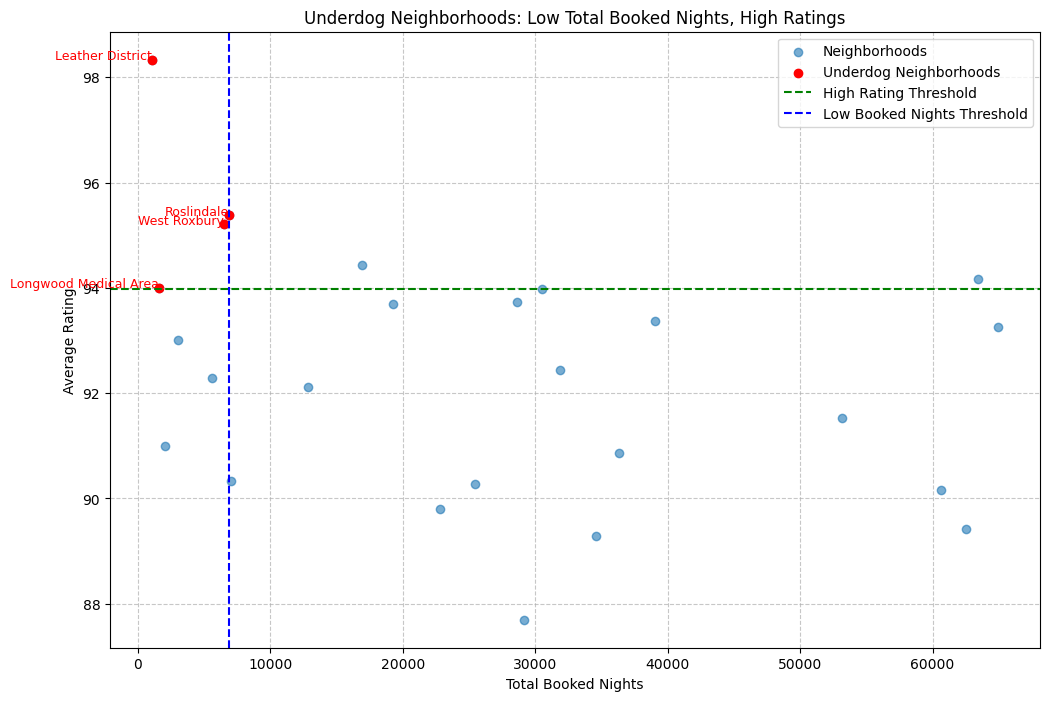

Underdog Neighborhoods:
   neighbourhood_cleansed  total_booked_nights  avg_rating
13       Leather District                 1100   98.333333
14  Longwood Medical Area                 1595   94.000000
18             Roslindale                 6899   95.380000
24           West Roxbury                 6509   95.212121


In [17]:
# Load data
listings = pd.read_csv('./Boston_listings.csv')
calendar = pd.read_csv('./Boston_calendar.csv')

# Step 1: Data preparation 
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)
calendar['available'] = calendar['available'].apply(lambda x: 1 if x == 't' else 0)

# Calculate the absolute number of booked nights per listing
calendar['booked_nights'] = 1 - calendar['available']  # Invert 'available' to 'booked'
booked_nights = calendar.groupby('listing_id')['booked_nights'].sum().reset_index()

# Merge with the listings
listings = listings.merge(booked_nights, how='left', left_on='id', right_on='listing_id')

# Aggregate at the neighborhood level
neighborhood_stats = listings.groupby('neighbourhood_cleansed').agg(
    total_booked_nights=('booked_nights', 'sum'),  # Total booked nights
    avg_rating=('review_scores_rating', 'mean'),
    count_listings=('id', 'count')
).reset_index()

# Step 2: Identifying underdogs
# Define thresholds
low_total_nights_threshold = neighborhood_stats['total_booked_nights'].quantile(0.25)  # Low booked nights
high_rating_threshold = neighborhood_stats['avg_rating'].quantile(0.75)               # High ratings

# Filter for underdogs
underdog_neighborhoods = neighborhood_stats[
    (neighborhood_stats['total_booked_nights'] <= low_total_nights_threshold) &
    (neighborhood_stats['avg_rating'] >= high_rating_threshold)
]

# Step 3: Visualization with annotations
plt.figure(figsize=(12, 8))
plt.scatter(neighborhood_stats['total_booked_nights'], neighborhood_stats['avg_rating'], alpha=0.6, label='Neighborhoods')
plt.scatter(
    underdog_neighborhoods['total_booked_nights'], underdog_neighborhoods['avg_rating'],
    color='red', label='Underdog Neighborhoods'
)

# Add threshold lines
plt.axhline(high_rating_threshold, color='green', linestyle='--', label='High Rating Threshold')
plt.axvline(low_total_nights_threshold, color='blue', linestyle='--', label='Low Booked Nights Threshold')

# Annotate underdog neighborhoods
for i, row in underdog_neighborhoods.iterrows():
    plt.text(
        row['total_booked_nights'], row['avg_rating'], 
        row['neighbourhood_cleansed'], fontsize=9, ha='right', color='red'
    )

# Axes and title
plt.xlabel('Total Booked Nights')
plt.ylabel('Average Rating')
plt.title('Underdog Neighborhoods: Low Total Booked Nights, High Ratings')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Display results
print("Underdog Neighborhoods:")
print(underdog_neighborhoods[['neighbourhood_cleansed', 'total_booked_nights', 'avg_rating']])


<ipython-input-37-2089e6f33e79>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings['price'] = listings['price'].replace(r'[\$,]', '', regex=True).astype(float)
<ipython-input-37-2089e6f33e79>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  listings['review_scores_rating'].filln

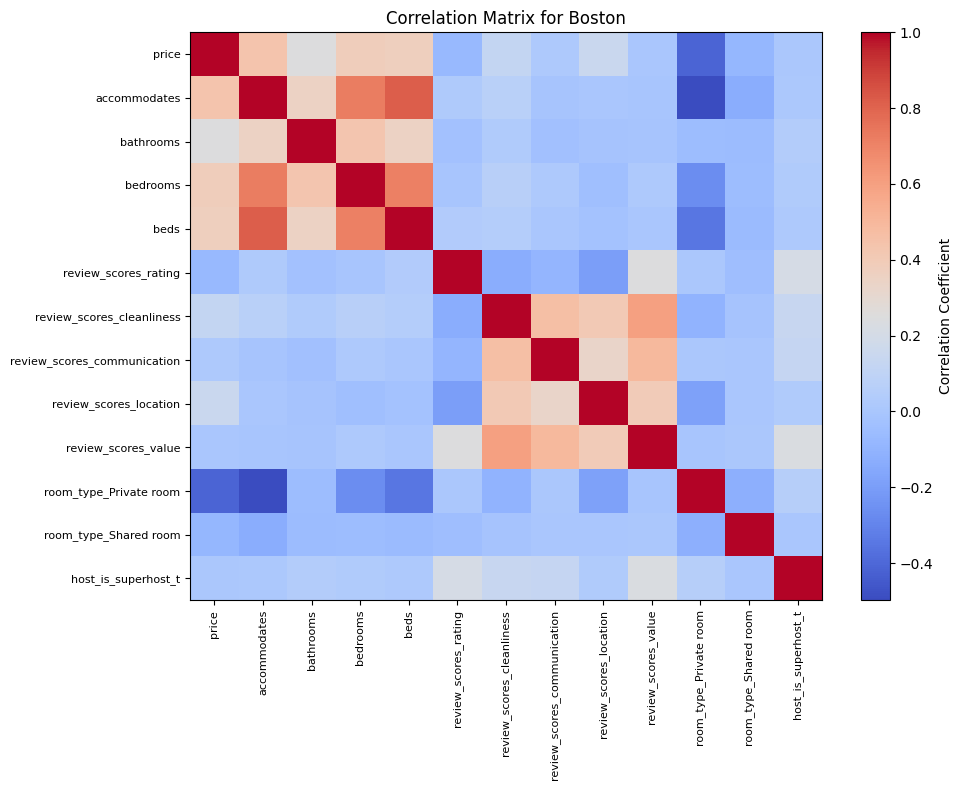

Root Mean Squared Error (RMSE): 20.964590529048976
Feature Importances:
                        Feature  Importance
8           review_scores_value    0.274752
5     review_scores_cleanliness    0.249074
7        review_scores_location    0.170991
0                         price    0.129884
6   review_scores_communication    0.053080
1                  accommodates    0.034763
11          host_is_superhost_t    0.029796
3                      bedrooms    0.019075
4                          beds    0.015931
2                     bathrooms    0.013507
9        room_type_Private room    0.008005
10        room_type_Shared room    0.001142


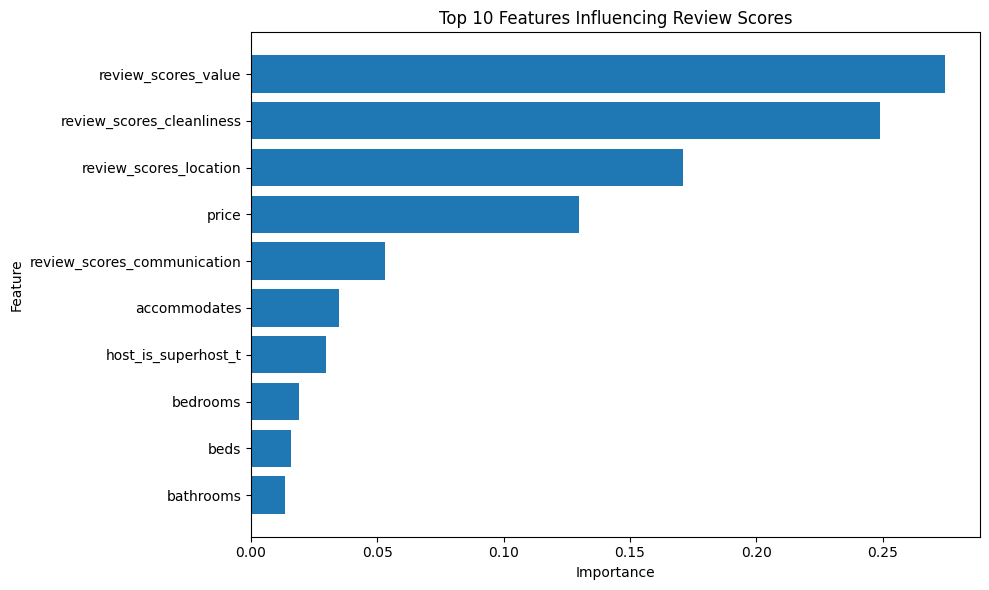

In [37]:
from sklearn.ensemble import RandomForestRegressor

# Daten laden
listings_boston = pd.read_csv('./Boston_listings.csv')

# Schritt 1: Datenvorbereitung
# Wichtige Spalten auswählen
columns_of_interest = [
    'price', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'review_scores_rating', 'review_scores_cleanliness',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'host_is_superhost'
]
listings = listings_boston[columns_of_interest]

# Preis bereinigen und in numerische Werte konvertieren
listings['price'] = listings['price'].replace(r'[\$,]', '', regex=True).astype(float)

# Sicherstellen, dass nur numerische Spalten für den Median genutzt werden
numeric_columns = listings.select_dtypes(include=[np.number]).columns

# Fehlende Werte auffüllen
listings['review_scores_rating'].fillna(0, inplace=True)  # Bewertungen mit 0 auffüllen
listings[numeric_columns] = listings[numeric_columns].fillna(listings[numeric_columns].median())  # Median für numerische Werte

# Dummy-Codierung für kategorische Variablen
listings = pd.get_dummies(listings, columns=['room_type', 'host_is_superhost'], drop_first=True)

# Verbleibende Schritte fortsetzen


# Schritt 2: Korrelationen untersuchen
correlations = listings.corr()

# Korrelationen visualisieren (Heatmap mit Matplotlib)
plt.figure(figsize=(10, 8))
plt.imshow(correlations, cmap='coolwarm', aspect='auto')
plt.colorbar(label="Correlation Coefficient")
plt.title('Correlation Matrix for Boston')
plt.xticks(range(correlations.shape[1]), correlations.columns, rotation=90, fontsize=8)
plt.yticks(range(correlations.shape[0]), correlations.columns, fontsize=8)
plt.tight_layout()
plt.show()

# Schritt 3: Vorhersage-Modell erstellen
# Zielvariable und Features definieren
X = listings.drop(columns=['review_scores_rating'])
y = listings['review_scores_rating']

# Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest Regressor trainieren
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Vorhersagen
y_pred = model.predict(X_test)

# Modellbewertung
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Schritt 4: Wichtige Features anzeigen
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances)

# Visualisierung der wichtigsten Einflussfaktoren
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'].head(10), feature_importances['Importance'].head(10))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features Influencing Review Scores')
plt.gca().invert_yaxis()  # Umkehren der Reihenfolge für besseren Lesefluss
plt.tight_layout()
plt.show()


        avg_price  availability_rate
month                               
1      182.799671           0.568348
2      180.961028           0.565792
3      181.818742           0.496384
4      197.252890           0.477617
5      193.712295           0.482162
6      196.535302           0.490156
7      202.486309           0.494423
8      203.330142           0.499802
9      237.047727           0.310448
10     233.416248           0.416899
11     202.924416           0.547388
12     192.601915           0.548702


<Figure size 1000x500 with 0 Axes>

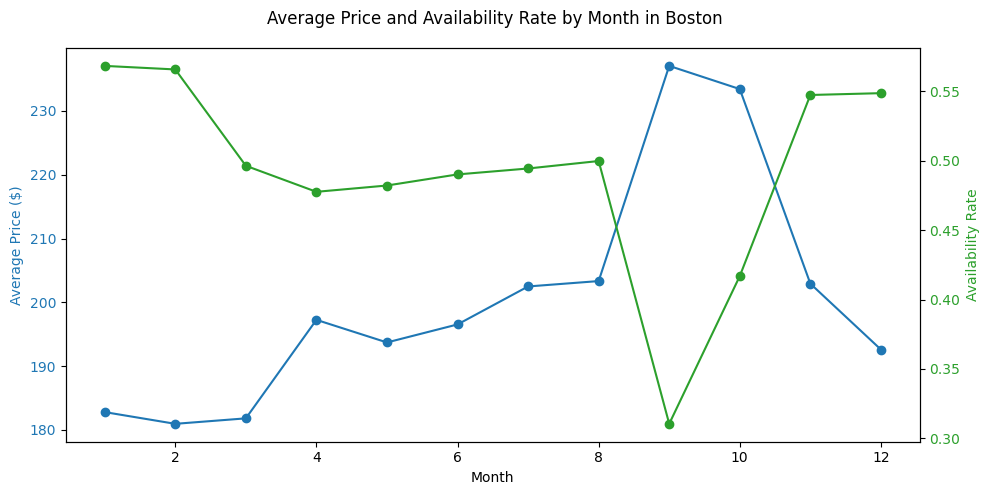

In [54]:
# Daten laden
calendar_boston = pd.read_csv('./Boston_calendar.csv')

# Preise bereinigen und konvertieren
def clean_price(price):
    if isinstance(price, str):
        return float(price.replace('$', '').replace(',', ''))
    return price

calendar_boston['price'] = calendar_boston['price'].apply(clean_price)

# Datum konvertieren
calendar_boston['date'] = pd.to_datetime(calendar_boston['date'])

# Monat extrahieren
calendar_boston['month'] = calendar_boston['date'].dt.month

# Durchschnittspreis und Verfügbarkeit pro Monat berechnen
boston_monthly = calendar_boston.groupby('month').agg({
    'price': 'mean',
    'available': lambda x: (x == 't').mean()
}).rename(columns={'price': 'avg_price', 'available': 'availability_rate'})
print(boston_monthly)
# Visualisierung
plt.figure(figsize=(10, 5))

# Kombiniertes Diagramm
fig, ax1 = plt.subplots(figsize=(10, 5))

# Preisdiagramm
color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Price ($)', color=color)
ax1.plot(boston_monthly.index, boston_monthly['avg_price'], label='Average Price', marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Verfügbarkeitsdiagramm
ax2 = ax1.twinx()  # Zweite Achse teilen
color = 'tab:green'
ax2.set_ylabel('Availability Rate', color=color)
ax2.plot(boston_monthly.index, boston_monthly['availability_rate'], label='Availability Rate', marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Titel und Layout
fig.suptitle('Average Price and Availability Rate by Month in Boston')
fig.tight_layout()
plt.show()
